# Machine Learning Project

### 1.1 - Find a dataset

For the project, we've decided to utilise the [Emotion Detection](https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer) dataset found on Kaggle, which consists of 35,685 images sorted into 7 categories. Images have a 48x48 pixel size and all are grayscale.

The dataset was already split into `train` and `test` datasets, with the `train` set holding ~80% of all images. Since we wanted to also have a dataset that we would use to fine-tune, and the `test` set already had a large number of images, we've decided to split it in half and turn it into the validation set. Thus, the final distribution of the dataset looks like `train` - 80%, `val` - 10%, and `test` - 10%.

[A recognising emotions through facial expressions study conducted by the University of Porto](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7599941/) shows that given 8 categories of human emotions, the mean agreement rate for humans is 82.0%, which will be chosen as our benchmark.

In [6]:
### Imports
# general
import tensorflow as tf
from tensorflow import keras

# visualisation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
from PIL import Image
%load_ext autoreload
%autoreload 2

# model, layers, optimiser
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Initially, all hyperparameters were initialised to default values as given by Keras and remained untouched during the process of building the model architecture.

### Hyperparameters

In [28]:
batch_size = 32
epochs = 10

# optimiser
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 1e-07

### Training and Test Data Import

In [10]:
train_dir = "datasets/train"
test_dir = "datasets/test"

The data normalised the grayscale levels (0-255) to values between (0-1) instead. This allows the model to have optimal comparisons between the pixels within the input data as it moves across the layers in the network.

In [11]:
img_size = 48
train_data = ImageDataGenerator(rescale = 1./255,
                               horizontal_flip = True, #Added in 2.1
                               vertical_flip = True) #Added in 2.1
test_data = ImageDataGenerator(rescale = 1./255, validation_split = 0.5)

train_gen = train_data.flow_from_directory(directory = train_dir,
                                           target_size = (img_size, img_size),
                                           batch_size = batch_size,
                                           color_mode = "grayscale",
                                           class_mode = "categorical")
val_gen = test_data.flow_from_directory(directory = test_dir,
                                       target_size = (img_size, img_size),
                                       batch_size = batch_size,
                                       color_mode = "grayscale",
                                       class_mode = "categorical",
                                       subset = "validation")
test_gen = test_data.flow_from_directory(directory = test_dir,
                                       target_size = (img_size, img_size),
                                       batch_size = batch_size,
                                       color_mode = "grayscale",
                                       class_mode = "categorical",
                                       subset = "training")

num_classes = len(train_gen.class_indices)
class_labels = list(test_gen.class_indices.keys())

Found 28709 images belonging to 7 classes.
Found 3587 images belonging to 7 classes.
Found 3591 images belonging to 7 classes.


#### Helper function to visualise loss and accuracy performance of the model

In [30]:
def show_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches((14, 4))

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(loss, label='Training set')
    ax1.plot(val_loss, label='Validation set', linestyle='--')
    ax1.legend()
    ax1.grid(linestyle='--', linewidth=1, alpha=0.5)

    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(accuracy, label="Training set")
    ax2.plot(val_accuracy, label="Validation set", linestyle='--')
    ax2.legend()
    ax2.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

### 1.2 - Build your model

In order to prevent the overfitted model from being saved, we've implemented the checkpoint system that keeps the model weights that result in the highest validation accuracy. As we are working with image data, we decided to jump in and design a Convolution Neural Network using what we have learnt in class. What we quickly learnt (and sometimes not so quickly depending on how fast the model train time took to complete) was that this is a very difficult task to gain high accuracy. It explains why this is a field that involves a lot of research as achieving a high-accuracy model takes a lot of intuitiveness, and thinking outside the box to achieve high performance. Some of our model architectures are outlined. Common among all models was the Adam optimiser, Categorical cross-entropy for the loss function, and accuracy for the metrics.

#### Model 1

The base architecture looks as follows:

|   | Layer Type   | Feature Map / Units | Kernel Size | Stride | Output Dimension | Activation |
|---|--------------|---------------------|-------------|--------|------------------|------------|
| - | Input        | 1                   | -           | -      | 48               | -          |
| 1 | Conv2D       | 6                   | 5           | 1      | 44               | ReLU       |
|   | MaxPooling2D | -                   | 2           | 2      | 22               | -          |
| 2 | Conv2D       | 16                  | 5           | 1      | 18               | ReLU       |
|   | MaxPooling2D | -                   | 2           | 2      | 9                | -          |
| - | Flatten      | -                   | -           | -      | 1296             | -          |
| 3 | Dense        | -                   | -           | -      | 120              | ReLU       |
| 4 | Dense        | -                   | -           | -      | 84               | ReLU       |
| 5 | Dense        | -                   | -           | -      | 7                | Softmax    |

Adam was used for the optimiser, Categorical cross-entropy for the loss function, and Accuracy for the metrics.

After running the model for 10 epochs, the validation accuracy stopped improving after Epoch 7, during which the model demonstrated the following performance:

`Train loss: 1.0379`
`Train accuracy: 0.6065`

`Val loss: 1.2555`
`Val accuracy: 0.5291`

<img src="graphs/model1.png" height="400px">

As seen on the graph, the validation loss starts going up after epoch 7, meaning that the model is overfitting the train data. Moreover, the train data had an accuracy that was pretty far from the benchmark we've established, indicating high bias.

#### Model 2

Our next model architecture improvement was going to tackle the problem of overfitting. During lectures, we learnt that augmentation and regularisation can improve this factor. Model 2.1 implements data augmentation, while Model 2.2 implements regularisation.

##### Model 2.1

For data augmentation, we've tried to use techniques that will bring a big variance to the images of the training dataset. For this, we've decided to employ horizontal and vertical flips.

After running the same model for 10 epochs, the validation accuracy stopped improving after Epoch 10, during which the model demonstrated the following performance:

`Train loss: 1.2613`
`Train accuracy: 0.5152`

`Val loss: 1.3327`
`Val accuracy: 0.4912`

<img src="graphs/model2.1.png" height="400px">

Despite the model losing almost 10% in the training accuracy, validation accuracy dropped only by 3%. Even though the rate of training slowed down significantly, the model kept on improving past Epoch 7, and, judging by the tendency that can be seen on the loss graph, it would continue to get better if we would increase the number of iterations. Also, the variance decreased significantly, from 7.74% without data augmentation to 2.4% with it.

##### Model 2.2

Another technique we've tried to use to decrease overfitting was regularisation. To achieve it, we've tried adding the Dropout layer to the architecture.

Since usually Dropout layers are used only for Dense layers, we've added those for two of our FC layers. The model at this stage didn't have a large number of parameters, and, due to the FC3 and FC4 together accounting for 98.13% of all trainable parameters, we've decided to choose a relatively small dropout rate of 0.25 to avoid dropping too many parameters during training.

Dense layer after modification:

| Layer Type | Activation |
|------------|------------|
| Dense      | ReLU       |
| Dropout    | -          |

With these modifications, the model demonstrated the following performance:

`Train loss: 1.3732`
`Train accuracy: 0.4724`

`Val loss: 1.3496`
`Val accuracy: 0.4815`

<img src="graphs/model2.2.png" height="400px">

Modifications caused the model to lose 4.28% of train accuracy and 0.97% of validation accuracy, but the variance decreased to just 0.91%. Moreover, the loss of both train and validation sets increased, identifying that the lost accuracy most likely will be regained when the model will be trained for a larger number of epochs.

#### Model 3

Our next model architecture improvement was going to tackle the problem of high bias. During lectures, we learnt that expanding the model architecture and increasing the number of epochs the model trains for can solve this problem. Since the latter one is part of the fine-tuning and in this section, we're trying to come up with the final structure of the model, for this iteration of development we've concentrated only on the addition of new layers to the architecture.

First of all, we've decided to increase the number of filters in the CNN layers, thus increasing the number of learnable parameters. Moreover, since the images we operate on are pretty small, to begin with, and we want to add more CNN layers, we've decided to change the kernel size in some layers to prevent the image from becoming too small after going through the Conv2D and MaxPooling2D layers, thus allowing the network to learn more features of facial emotions. Additionally, since max-pooling was making the image too small, we've decided to not add it at every CNN layer, instead leaving it only in the first two and last one.

Since the network is getting deeper and training time increases, we've decided to add batch normalisation layers after Conv2D and Dense layers in order to speed up the gradient descent and introduce some new randomness, thus decreasing variance. The modified architecture looks as follows:

|   | Layer Type         | Feature Map / Units | Kernel Size | Stride | Output Dimension | Activation |
|---|--------------------|---------------------|-------------|--------|------------------|------------|
| - | Input              | 1                   | -           | -      | 48               | -          |
| 1 | Conv2D             | 22                  | 3           | 1      | 46               | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | MaxPooling2D       | -                   | 2           | 2      | 23               | -          |
| 2 | Conv2D             | 64                  | 3           | 1      | 21               | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | MaxPooling2D       | -                   | 2           | 2      | 10               | -          |
| 3 | Conv2D             | 96                  | 3           | 1      | 8                | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
| 4 | Conv2D             | 96                  | 3           | 1      | 6                | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
| 5 | Conv2D             | 64                  | 3           | 1      | 4                | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | MaxPooling2D       | -                   | 2           | 2      | 2                | -          |
| - | Flatten            | -                   | -           | -      | 2304             | -          |
| 6 | Dense              | -                   | -           | -      | 256              | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | Dropout            |                     |             |        |                  |            |
| 7 | Dense              | -                   | -           | -      | 128              | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | Dropout            |                     |             |        |                  |            |
| 8 | Dense              | -                   | -           | -      | 7                | Softmax    |

With these modifications, the model demonstrated the following performance:

`Train loss: 1.1608`
`Train accuracy: 0.5602`

`Val loss: 1.2031`
`Val accuracy: 0.5434`

<img src="graphs/model3.png" height="400px">

##### Model 3.1

Since the bias was still pretty high and the model wasn't converging fast enough, we've decided to increase the number of convolutional layers. Due to the small size of the input images, we've added the padding option to the CNN layers in order to preserve their dimensions. Furthermore, we've placed the CNN layers in blocks of two before passing the output through MaxPooling2D, allowing the network to learn features on a larger-sized image. Since the network learns more complex features in later stages, we've interchanged the FC6 and FC7. The modified architecture looks as follows:

|   | Layer Type         | Feature Map / Units | Kernel Size | Stride | Output Dimension | Activation |
|---|--------------------|---------------------|-------------|--------|------------------|------------|
| - | Input              | 1                   | -           | -      | 48               | -          |
| 1 | Conv2D             | 22                  | 3           | 1      | 48               | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
| 2 | Conv2D             | 22                  | 3           | 1      | 48               | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | MaxPooling2D       | -                   | 2           | 2      | 24               | -          |
| 3 | Conv2D             | 64                  | 3           | 1      | 24               | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
| 4 | Conv2D             | 64                  | 3           | 1      | 24               | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | MaxPooling2D       | -                   | 2           | 2      | 12               | -          |
| 5 | Conv2D             | 96                  | 3           | 1      | 12               | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
| 6 | Conv2D             | 96                  | 3           | 1      | 12               | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | MaxPooling2D       | -                   | 2           | 2      | 6                | -          |
| - | Flatten            | -                   | -           | -      | 3456             | -          |
| 7 | Dense              | -                   | -           | -      | 128              | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | Dropout            |                     |             |        |                  |            |
| 8 | Dense              | -                   | -           | -      | 256              | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | Dropout            |                     |             |        |                  |            |
| 9 | Dense              | -                   | -           | -      | 7                | Softmax    |

With these modifications, model demonstrated the following performance:

`Train loss: 1.0640`
`Train accuracy: 0.5959`

`Val loss: 1.0878`
`Val accuracy: 0.5933`

<img src="graphs/model3.1.png" height="400px">

##### Model 3.2

An experimental run with more epochs revealed that validation loss converges slightly faster than the training loss and barely improves after epoch 10, causing a big variation if early stopping isn't enforced. Thus, we've attempted to include more variance-decreasing techniques.

Since the model is built mostly on convolutional layers and traditionally dropout isn't performed with CNNs, we've tried to add dropout layers with very small dropout rates of 0.1. Nonetheless, the test run indicated that the rate of convergence of training loss didn't change much, while validation accuracy dropped and converged to 55%, thus exacerbating the issue.

The last technique we tried was L2 Regularisation. To test how adding regularisation will affect overall performance we've used the default value of 0.1. First, we've verified that CNN layers with added L2 don't perform well and have a similar effect on the model as the dropout. Adding L2 to FC7 and FC8 managed to decrease the rate at which the model was training, keeping variation within 1% throughout most of the training period. Nonetheless, at epoch 15 the validation loss started to converge to the same 59%, and variation kept on growing henceforth. Thus, even though it took the model significantly more epochs to achieve the same performance as in the previous model version, it didn't improve the problem of early convergence at all.

#### Model 4 

As we were not having much luck on our own to develop a reliable model architecture to perform our task, research was then conducted to see what is being done in the world of academia. A [ResNET (Residual Neural Network)](https://datagen.tech/guides/computer-vision/resnet/#:~:text=Residual%20Network%20(ResNet)%20is%20a,or%20thousands%20of%20convolutional%20layers) was adopted which feeds back the inputs into deeper layers to provide a workaround for the “vanishing gradient”. The vanishing gradient could be the issue we have been observing with our previous models where the deeper we go in our model, the more information gets lost as the partial derivatives are too small from the backpropagation step and the weights never get improved. Training then seems to stand still and that is most likely causing our validation accuracy to remain the same while our training data just gets overfitted.

The hyperparameter for epoch was adjusted to 30 which did not seem to yield much improvement in training data which makes clear the model structure is unable to learn effectively yet and requires further revising.


|   | Layer Type         | Feature Map / Units | Kernel Size | Stride | Output Dimension | Activation |
|---|--------------------|---------------------|-------------|--------|------------------|------------|
| - | Input              | 1                   | -           | -      | 48               | -          |
| 1 | Conv2D with pad    | 16                  | 3           | 1      | 48               | ReLU       |
| 2 | Conv2D with pad    | 24                  | 3           | 1      | 48               | ReLU       |
| 3 | Conv2D with pad    | 20                  | 3           | 1      | 48               | ReLU       |
| 4 | Conv2D with pad    | 24                  | 3           | 1      | 48               | ReLU       |
| 5 | Add Input with 4   | 24                  | -           | -      | 48               | -          |
| 6 | Conv2D with pad    | 32                  | 3           | 1      | 48               | ReLU       |
| 7 | Conv2D with pad    | 24                  | 3           | 1      | 48               | ReLU       |
| 8 | Add Input with 7   | 24                  | -           | -      | 48               | -          |
| 9 | Conv2D             | 16                  | 3           | 1      | 46               | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|10 | Conv2D             | 20                  | 3           | 1      | 44               | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|11 | Conv2D             | 64                  | 3           | 1      | 4                | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | MaxPooling2D       | -                   | 2           | 2      | 22               | -          |
| - | Flatten            | -                   | -           | -      | 9680             | -          |
|12 | Dense              | -                   | -           | -      | 256              | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | Dropout            |                     |             |        |                  |            |
|13 | Dense              | -                   | -           | -      | 128              | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | Dropout            |                     |             |        |                  |            |
|14 | Dense              | -                   | -           | -      | 84               | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | Dropout            |                     |             |        |                  |            |
|15 | Dense              | -                   | -           | -      | 32               | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | Dropout            |                     |             |        |                  |            |
| 8 | Dense              | -                   | -           | -      | 7                | Softmax    |

The model diagram had an interesting look with the input being fed into later convolution layers:

<img src="diagrams/model4.png" height="700px">

With these modifications, the model demonstrated the following performance:

`Train loss: 0.8589`
`Train accuracy: 0.6908`

`Val loss: 1.3390`
`Val accuracy:  0.5222`

<img src="graphs/model4.png" height="400px">

#### Model 5

Since the ResNet was not achieving better results, more research yielded [AlexNet](https://neurohive.io/en/popular-networks/alexnet-imagenet-classification-with-deep-convolutional-neural-networks/).


|   | Layer Type         | Feature Map / Units | Kernel Size | Stride | Output Dimension | Activation |
|---|--------------------|---------------------|-------------|--------|------------------|------------|
| - | Input              | 1                   | -           | -      | 48               | -          |
| 1 | Conv2D             | 96                  | 3           | 1      | 46               | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
| 3 | Conv2D             | 256                 | 3           | 1      | 44               | ReLU       |
| 4 | Conv2D             | 256                 | 3           | 1      | 42               | ReLU       |
| 5 | Conv2D             | 384                 | 3           | 1      | 40               | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | MaxPooling2D       | -                   | 2           | 2      | 20               | -          |
| - | Flatten            | -                   | -           | -      | 185856           | -          |
| 6 | Dense              | -                   | -           | -      | 4096             | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | Dropout            |                     |             |        |                  |            |
| 7 | Dense              | -                   | -           | -      | 4096             | ReLU       |
|   | BatchNormalization | -                   | -           | -      | -                | -          |
|   | Dropout            |                     |             |        |                  |            |
| 8 | Dense              | -                   | -           | -      | 7                | Softmax    |

The computation time on a convolution network ended up taking a long time and we were in danger of burning out our laptops. The graph ended up performing similarly as the ResNet performance.

### Final model

Since out of the past three models the one with the best performance was 3.1, we've decided to stick with its architecture to continue onto the next stage of fine-tuning.

In [12]:
def create_model():
    model = Sequential([
        # Input
        Input(shape=(img_size, img_size, 1)),
        ## Block1
        # Conv1
        Conv2D(22, kernel_size=(3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        # Conv2
        Conv2D(22, kernel_size=(3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        ## Block2
        # Conv3
        Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        # Conv4
        Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        ## Block3
        # Conv5
        Conv2D(96, kernel_size=(3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        # Conv6
        Conv2D(96, kernel_size=(3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        Flatten(),
        # FC7
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.25),
        # FC8
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.25),
        # FC9 / Output
        Dense(num_classes, activation="softmax")
    ])
    optimiser = Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2, epsilon=eps)
    model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model

In [32]:
# Train model
model = create_model()
model_checkpoint_callback = ModelCheckpoint("model_weights.h5", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=True, mode="max")
history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data = val_gen, callbacks=[model_checkpoint_callback])

Epoch 1/10
898/898 [==============================] - ETA: 0s - loss: 1.9320 - accuracy: 0.2664
Epoch 1: val_accuracy improved from -inf to 0.34290, saving model to model_weights.h5
898/898 [==============================] - 58s 63ms/step - loss: 1.9320 - accuracy: 0.2664 - val_loss: 1.6681 - val_accuracy: 0.3429
Epoch 2/10
898/898 [==============================] - ETA: 0s - loss: 1.5248 - accuracy: 0.4086
Epoch 2: val_accuracy improved from 0.34290 to 0.44466, saving model to model_weights.h5
898/898 [==============================] - 53s 59ms/step - loss: 1.5248 - accuracy: 0.4086 - val_loss: 1.4409 - val_accuracy: 0.4447
Epoch 3/10
898/898 [==============================] - ETA: 0s - loss: 1.3550 - accuracy: 0.4796
Epoch 3: val_accuracy improved from 0.44466 to 0.50293, saving model to model_weights.h5
898/898 [==============================] - 56s 63ms/step - loss: 1.3550 - accuracy: 0.4796 - val_loss: 1.2942 - val_accuracy: 0.5029
Epoch 4/10
898/898 [=============================

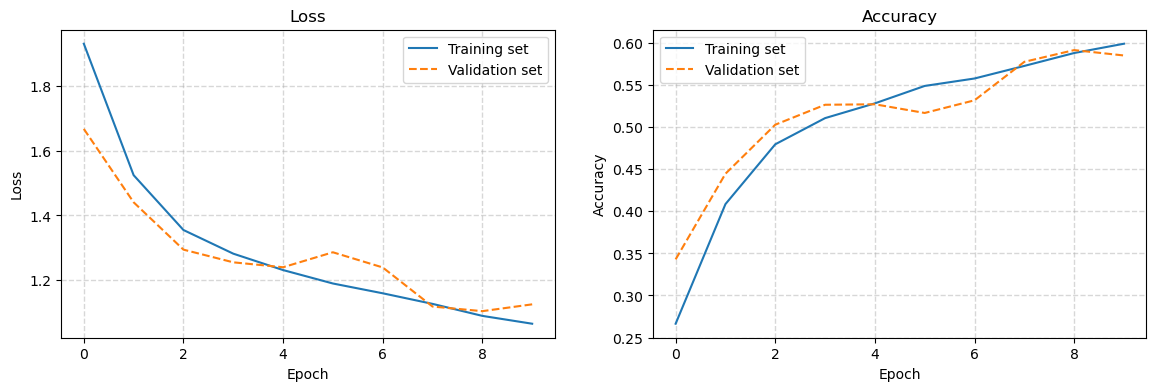

In [33]:
show_history(history)

### 1.3 - Idea, Code, Experiment Cycle

Since different hyperparameters can lead to improvements, but may take a larger number of epochs to converge to better-performing values, we've increased the number of iterations to have a better understanding of the modified model's behaviour. For the most part, we've used the Grid method to test different hyperparameters and estimate their effect on the model performance, while using the Coarse to Fire method to approximate good values for exponential decay rates.

For the Learning Rate and the Exponential Decay Rates, an Epoch of 30 was used to observe the effects of the parameters on the performance.

#### Learning rate

##### Learning Rate = 0.001 - Default
<img src="graphs/alpha-point001.png" height="400px">

##### Learning Rate = 0.01
<img src="graphs/alpha-point01.png" height="400px">

##### Learning Rate = 0.0009
<img src="graphs/alpha-point0009.png" height="400px">

##### Learning Rate = 0.009
<img src="graphs/alpha-point009.png" height="400px">

##### Learning Rate = 0.09
<img src="graphs/alpha-point09.png" height="400px">

##### Conclusion on Altering Learning Rate

To start with the odd one out, a really high learning rate does not appear to allow the model to perform proper gradient descent as discussed in lecture. The training showed no change in performance.

The other learning rate adjustments showed that the model was hovering around roughly 60% validation accuracy.

#### Exponential decay rates

#### Beta 1

##### Beta1 = 0.88
<img src="graphs/beta1-point88.png" height="400px">

##### Beta1 = 0.80
<img src="graphs/beta1-point80.png" height="400px">

##### Beta1 = 0.75
<img src="graphs/beta1-point75.png" height="400px">

##### Beta1 = 0.70
<img src="graphs/beta1-point70.png" height="400px">

#### Beta 2

These values were adjusted with Beta1 at 0.85 or 0.88 to observe any effects:

##### Beta1 = 0.85 and Beta2 = 0.85
<img src="graphs/beta1-point85 beta2-point85.png" height="400px">

##### Beta1 = 0.85 and Beta2 = 0.95
<img src="graphs/beta1-point85 beta2-point95.png" height="400px">

##### Beta1 = 0.88 and Beta2 = 0.98
<img src="graphs/beta1-point88 beta2-point98.png" height="400px">

##### Beta1 = 0.88 and Beta2 = 0.99
<img src="graphs/beta1-point88.png" height="400px">

##### Conclusion on Altering Exponential Decay Rates

There seemed to be no gains with impacting the optimizer properties. All we can observe in these plots is the overfitting effect of running more iterations on the training data. 

#### Minibatch size

Since the increase of minibatch size leads to the model acting closer to the batch gradient descent, we've tried different values higher than the default 32 that was used previously to see if the model will be able to converge to a higher validation accuracy due to the smoother convex zoom into a minimum. Also, for the sake of experimenting, we've tried to run the model with a smaller minibatch size to check if the model will generalise better by not converging too sharply to the minimisers of the training function.

##### 16

After 10 epochs:

`Train loss: 1.1235`
`Train accuracy: 0.5757`

`Val loss: 1.1334`
`Val accuracy: 0.5790`

After 16 epochs:

`Train loss: 1.0225`
`Train accuracy: 0.6201`

`Val loss: 1.0845`
`Val accuracy: 0.5988`

<img src="graphs/batch16.png" height="400px">

##### 32

After 10 epochs:

`Train loss: 1.0645`
`Train accuracy: 0.5951`

`Val loss: 1.0876`
`Val accuracy: 0.5937`

After 16 epochs:

`Train loss: 0.9602`
`Train accuracy: 0.6409`

`Val loss: 1.0893`
`Val accuracy: 0.6050`

<img src="graphs/batch32.png" height="400px">

##### 64

After 10 epochs:

`Train loss: 1.0586`
`Train accuracy: 0.5985`

`Val loss: 1.1255`
`Val accuracy: 0.5762`

After 16 epochs:

`Train loss: 0.9335`
`Train accuracy: 0.6501`

`Val loss: 1.0878`
`Val accuracy: 0.6027`

<img src="graphs/batch64.png" height="400px">

##### 128

After 10 epochs:

`Train loss: 1.0630`
`Train accuracy: 0.5957`

`Val loss: 1.1297`
`Val accuracy: 0.5721`

After 16 epochs, the model stopped improving on epoch 15

`Train loss: 0.9544`
`Train accuracy: 0.6428`

`Val loss: 1.0981`
`Val accuracy: 0.6041`

<img src="graphs/batch128.png" height="400px">

##### 256

After 10 epochs:

`Train loss: 1.1056`
`Train accuracy: 0.5818`

`Val loss: 1.2004`
`Val accuracy: 0.5520`

After 16 epochs:

`Train loss: 1.0042`
`Train accuracy: 0.6213`

`Val loss: 1.1371`
`Val accuracy: 0.5651`

<img src="graphs/batch256.png" height="400px">

##### Conclusion on Altering Mini-batch Sizes

As evident from the data above, a batch size of 32 gave the fastest convergence to the converging value of 60% in only 10 epochs. Running the model for 6 more iterations didn't improve the performance on the validation set, but did lead to overfitting.

Decreasing the size to 16 took longer to train the model to the same level of performance on the validation set, but also caused variance to go up by 2.13%. As seen from the graph, it doesn't appear that the model will converge to higher validation accuracy and smaller variance.

Increasing the size of the minibatch proved to reduce the model's ability to generalise, having variances of 2.23%, 2.36%, and 2.98% for sizes 64, 128, and 256 respectively after just 10 epochs. The variance only continued to grow in the next 6 iterations due to the validation accuracy being stuck at ~60%. As seen from the loss graphs, this trend will continue in further epochs as well, thus not improving the model.

#### Epsilon

##### 1e-07

After 10 epochs:

`Train loss: 1.0645`
`Train accuracy: 0.5951`

`Val loss: 1.0876`
`Val accuracy: 0.5937`

After 16 epochs:

`Train loss: 0.9602`
`Train accuracy: 0.6409`

`Val loss: 1.0893`
`Val accuracy: 0.6050`

<img src="graphs/batch32.png" height="400px">

##### 1e-06

After 10 epochs:

`Train loss: 1.0811`
`Train accuracy: 0.5935`

`Val loss: 1.1342`
`Val accuracy: 0.5740`

After 16 epochs:

`Train loss: 0.9521`
`Train accuracy: 0.6450`

`Val loss: 1.0715`
`Val accuracy: 0.6055`

<img src="graphs/eps10.png" height="400px">

##### 1e-05

After 10 epochs, the model stopped improving on epoch 9

`Train loss: 1.0995`
`Train accuracy: 0.5833`

`Val loss: 1.1248`
`Val accuracy: 0.5821`

After 16 epochs:

`Train loss: 0.9477`
`Train accuracy: 0.6489`

`Val loss: 1.0731`
`Val accuracy: 0.6055`

<img src="graphs/eps100.png" height="400px">

##### 1e-04

After 10 epochs, the model stopped improving on epoch 8

`Train loss: 1.1310`
`Train accuracy: 0.5734`

`Val loss: 1.1028`
`Val accuracy: 0.5849`

After 16 epochs, the model stopped improving on epoch 15

`Train loss: 0.9621`
`Train accuracy: 0.6410`

`Val loss: 1.0348`
`Val accuracy: 0.6136`

<img src="graphs/eps1000.png" height="400px">

##### 1e-03

After 10 epochs, the model stopped improving on epoch 9

`Train loss: 1.0916`
`Train accuracy: 0.5870`

`Val loss: 1.1271`
`Val accuracy: 0.5829`

After 16 epochs, the model stopped improving on epoch 15

`Train loss: 0.9627`
`Train accuracy: 0.6424`

`Val loss: 1.0607`
`Val accuracy: 0.6103`

<img src="graphs/eps10000.png" height="400px">

##### Conclusion on altering Epsilon

After testing 1e-03 it was evident that performance started to go down both in terms of accuracy and variance, thus it was decided to stop experimenting with different values of epsilon at this value.

As seen from the data, 1e-07 and 1e-05 both achieved satisfactory results after 10 epochs, giving very low variance for models after being run for 10 epochs. However, even though 1e-05 had 0.02% better variance in comparison to 1e-07, its accuracy was 1.16% lower. When being run for 16 epochs, both models had bad variance scores, but the first one had the lower one with a value of 3.59%.

When looking at performance after 16 iterations, all values of epsilon give poor variance. Utilising 1e-04 resulted in the highest validation accuracy of 61.36% and lowest variance of 2.74%, which is 0.67% better in terms of accuracy and 0.15% in terms of the variance than what the model with an epsilon of 1e-07 was converging to.

Overall, the choice in epsilon lies between 1e-07 and 1e-04, with the first one giving good accuracy and low variance, whereas the latter one gives a slight increase in accuracy at the cost of minor overfitting and longer training. The final decision depends on which of the two performance aspects we are willing to sacrifice.

#### Epochs

Since the idea of early stopping is in halting the training process before the model starts to overfit, we've run the model for 30 epochs to see when the difference between training accuracy and validation accuracy starts to increase.

<img src="graphs/beta1-point88 beta2-point98.png" height="400px">

From the graph it is evident, that after 10 epochs the variation increases significantly due to the validation accuracy converging to the usual 60% and training accuracy continuing to grow, thus causing overfitting. Accordingly, we've decided to set the number of epochs to 10.

`Train loss: 1.0726`
`Train accuracy: 0.5943`

`Val loss: 1.0934`
`Val accuracy: 0.5882`

**Number of layers and number of units hyperparameters have been tuned during the process of creating the model**

In [7]:
# Hyper parameter tuning
batch_size = 32
epochs = 10

# optimiser
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 1e-07 #or 1e-04 for slightly more accuracy with +6 epochs training time and higher variance

In [35]:
# Test new hyperparams
model = create_model()
model_checkpoint_callback = ModelCheckpoint("model_weights.h5", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=True, mode="max")
history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data = val_gen, callbacks=[model_checkpoint_callback])

Epoch 1/10
898/898 [==============================] - ETA: 0s - loss: 1.8726 - accuracy: 0.2925
Epoch 1: val_accuracy improved from -inf to 0.41399, saving model to model_weights.h5
898/898 [==============================] - 56s 61ms/step - loss: 1.8726 - accuracy: 0.2925 - val_loss: 1.5034 - val_accuracy: 0.4140
Epoch 2/10
898/898 [==============================] - ETA: 0s - loss: 1.4738 - accuracy: 0.4316
Epoch 2: val_accuracy improved from 0.41399 to 0.45721, saving model to model_weights.h5
898/898 [==============================] - 54s 60ms/step - loss: 1.4738 - accuracy: 0.4316 - val_loss: 1.3958 - val_accuracy: 0.4572
Epoch 3/10
898/898 [==============================] - ETA: 0s - loss: 1.3373 - accuracy: 0.4870
Epoch 3: val_accuracy improved from 0.45721 to 0.52467, saving model to model_weights.h5
898/898 [==============================] - 55s 62ms/step - loss: 1.3373 - accuracy: 0.4870 - val_loss: 1.2472 - val_accuracy: 0.5247
Epoch 4/10
898/898 [=============================

#### Test

Evaluating the final model performance on data it wasn't trained or fine-tuned on

In [36]:
# Evaluate Test
model = create_model()
model.load_weights("model_weights.h5")

eval_test = model.evaluate(test_gen, verbose=0)
print("Test loss:", eval_test[0])
print("Test accuracy:", eval_test[1])

Test loss: 1.0803444385528564
Test accuracy: 0.5923141241073608


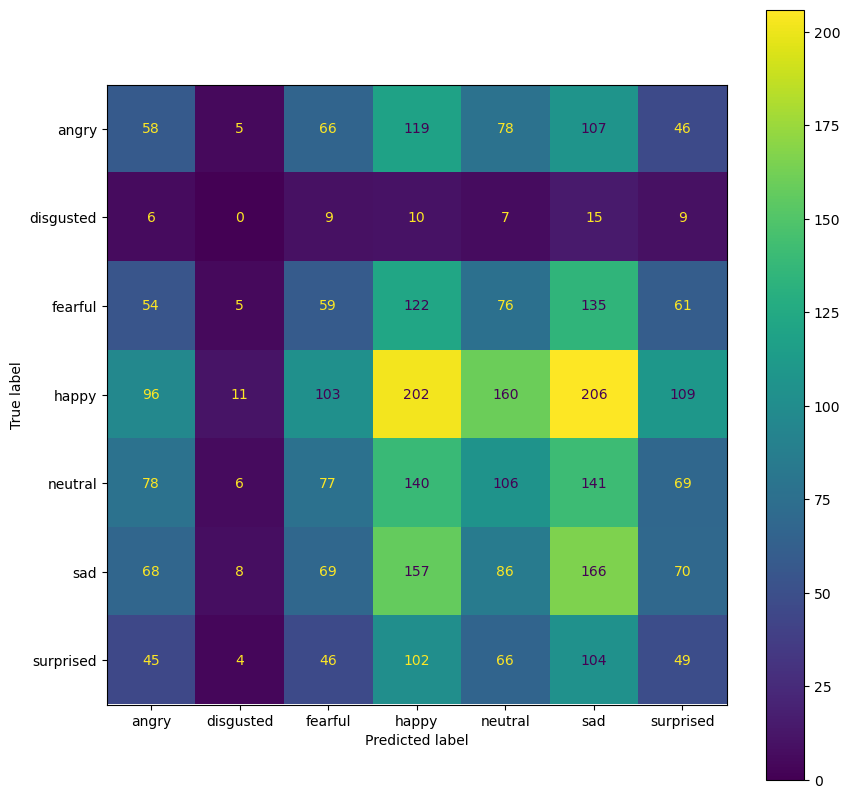

In [37]:
# Confusion matrix (in case if sklearn installed)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred_class = np.argmax(model.predict(test_gen, verbose=0), axis=1)
true_class = test_gen.classes
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_class, pred_class), display_labels=class_labels)
fig, ax = plt.subplots(figsize=(10,10))
display.plot(ax=ax)
plt.show()

#### Test custom images

In [13]:
def predict_custom(img_dir):
    model = create_model()
    img = keras.preprocessing.image.load_img(img_dir, target_size = (img_size, img_size), color_mode = "grayscale")
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    pred = model.predict(img_array, verbose=0)
    pred_class_indices = np.argmax(pred, axis=1)
    return class_labels[pred_class_indices[0]]

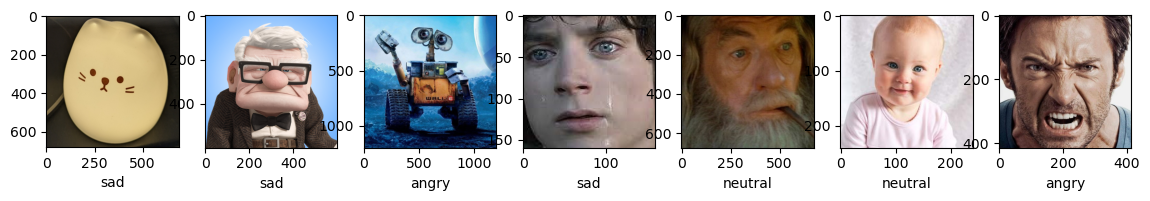

In [19]:
# Test custom images
model = create_model()
model.load_weights("model_weights.h5")

img1 = 'images/cat.jpg'
img2 = 'images/carl.jpeg'
img3 = 'images/walle.jpg'
img4 = 'images/frodosad.jpeg'
img5 = 'images/gandalfsurprised.jpg'
img6 = 'images/happybaby.jpg'
img7 = 'images/angrylogan.jpg'

fig, axarr = plt.subplots(1, 7)
fig.set_size_inches((14, 4))
axarr[0].imshow(Image.open(img1))
axarr[0].set_xlabel(predict_custom(img1))
axarr[1].imshow(Image.open(img2))
axarr[1].set_xlabel(predict_custom(img2))
axarr[2].imshow(Image.open(img3))
axarr[2].set_xlabel(predict_custom(img3))
axarr[3].imshow(Image.open(img4))
axarr[3].set_xlabel(predict_custom(img4))
axarr[4].imshow(Image.open(img5))
axarr[4].set_xlabel(predict_custom(img5))
axarr[5].imshow(Image.open(img6))
axarr[5].set_xlabel(predict_custom(img6))
axarr[6].imshow(Image.open(img7))
axarr[6].set_xlabel(predict_custom(img7))
plt.show()

Note: These images were found from a Google Image Search

### Conclusions

In the end, the constructed model didn't manage to achieve the benchmark we defined at the beginning of the project, thus having a relatively big bias of ~22%. Nonetheless, the result can still be considered a success. Despite advancements that were done by machine learning, emotion recognition in general is still a surprisingly challenging topic. [Several pieces of research](https://journals-sagepub-com.proxy.lib.sfu.ca/doi/full/10.1111/j.1467-9280.2009.02350.x) indicate that facial expression classification is not easy for human beings as well, with people from different cultures interpreting facial features in different ways.

When it comes to existing statistical models that try to evaluate a person's emotions based on their facial expressions, the [AVCE](https://link-springer-com.proxy.lib.sfu.ca/chapter/10.1007/978-3-031-19778-9_11) based on reduced AlexNet or ResNet18 seems to be the latest advancement. Despite using a model architecture that has 17 times more parameters compared to ours, having only 4 categories to be classified, and a dataset that's significantly larger, the accuracy of their model is better only by ~7%. Thus, with our model being significantly lighter, the results we've achieved are satisfactory.

Another big source of high bias relies on the dataset we've chosen. Images within categories have a lot of dissimilarities between them, but the bigger issue is that many of them have exceptionally similar to images from other classes. As an example, all of these images look `neutral`, even though they're taken from other datasets.

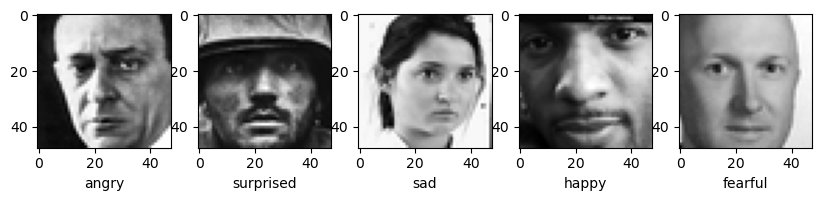

In [5]:
fig, axarr = plt.subplots(1, 5)
fig.set_size_inches((10, 4))
axarr[0].imshow(Image.open('datasets/train/angry/im94.png'), cmap="gray")
axarr[0].set_xlabel("angry")
axarr[1].imshow(Image.open('datasets/train/surprised/im2544.png'), cmap="gray")
axarr[1].set_xlabel("surprised")
axarr[2].imshow(Image.open('datasets/train/sad/im16.png'), cmap="gray")
axarr[2].set_xlabel("sad")
axarr[3].imshow(Image.open('datasets/train/happy/im308.png'), cmap="gray")
axarr[3].set_xlabel("happy")
axarr[4].imshow(Image.open('datasets/train/fearful/im5.png'), cmap="gray")
axarr[4].set_xlabel("fearful")
plt.show()

Moreover, the categories didn't have an equal number of images in the dataset. For example, the abominable performance of the model during the prediction of the `disgusted` category can be explained by it having 11 times fewer images than any other class. On the contrary, the `happy` class had the most number of images, and thus, as seen on the confusion chart, it performed the best out of all categories.

We learnt a lot of important lessons about the field of Computer Vision during this project. For one, we learnt that what we are indeed training on unstructured data to fine-tune parameters and hyperparameters is an art form in itself. Designing a model that performs well (high %) from the start is also difficult without having to also consider tweaking the hyperparameters.

We also learnt the importance of regularisation, with the adoption of dropout being important, to prevent overfitting a model. It is easy to throw more iterations at a model to get higher accuracy on the training data, but on the validation and test data, that does not mean it's going to perform just as well, which is something we observed

It is no surprise after doing this project that computer vision and getting machines to accurately describe what is in a picture is a huge research area and that most research articles published are about a model for a specific task. It takes a lot of testing, iterating, and refining of the model, and input data to achieve the results. The other key factor though is time.

Running the training set on our small laptops took a lot of time (more than 20 minutes for a training run on 10 epochs but closer to an hour on 30 epochs), and it is no wonder why sometimes it can take months to train these research data sets. A powerful computer is important, and managing the minibatch is crucial when working with a lower-spec computer.